# ECE-GY 9293 HW3 Guandong Kou (gk1675)

In [1]:
run ../styles.ipynb

## Problem 1

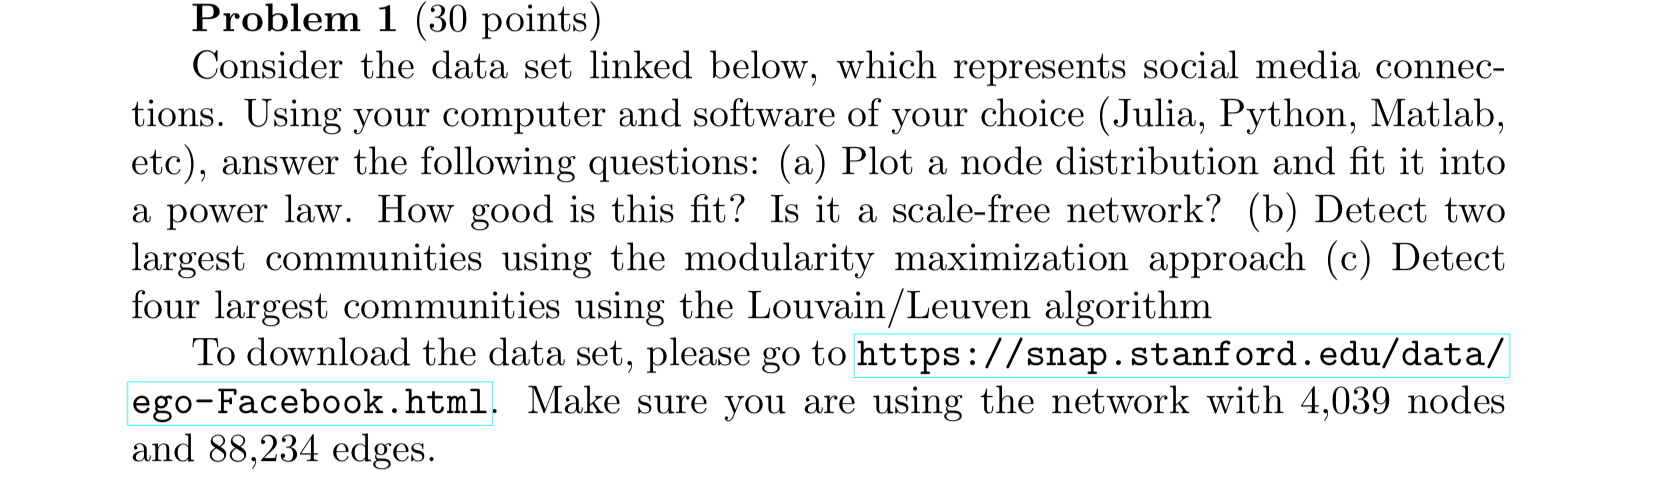

### 1a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import networkx as nx
from collections import Counter
from sklearn.linear_model import LinearRegression as LR

In [2]:
G = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph()) # separate data-reading step

In [3]:
class Problem1():
    def __init__(self):
        global G
        self.G = G
        
    def get_distribution(self):
        deg_sequence = sorted([deg for node, deg in self.G.degree()], reverse=True)
        self.k_counter = Counter(deg_sequence)
        self.k_values = np.array(sorted(filter(lambda x: x>0, list(self.k_counter.keys())))) # k_min = 1
        self.p_k = np.array([self.k_counter[k] for k in self.k_values]) / len(deg_sequence) # probability of k
        self.size_k = self.k_values.size

    def visualize_distribution(self):
        plt.figure()
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        ax[0].scatter(self.k_values, self.p_k, s=2)
        ax[0].set_xlabel('degree ($k$);');
        ax[0].set_ylabel('$p_k$');
        ax[1].scatter(self.k_values, self.p_k, s=2)
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].set_xlim(10**(-0.1), 10**3.5)
        ax[1].set_ylim(10**(-4), 0.1)
        ax[1].set_xlabel('degree ($k$);');
        ax[1].set_ylabel('$p_k$');
        plt.show()

    def fit_params(self):
        self.log_k = np.log(self.k_values).reshape(self.size_k, 1)
        self.log_pk = np.log(self.p_k).reshape(self.size_k, 1)
        # use linear regression model to fit the logarithm values of k and p_k
        self.model = LR().fit(self.log_k, self.log_pk)
        self.alpha, self.c = self.model.coef_.ravel(), self.model.intercept_
        return self.alpha, self.c
        
    def plot_fitted(self):
        xx = np.array([min(self.log_k), max(self.log_k)])
        yy = self.alpha * xx + self.c
        plt.scatter(self.log_k, self.log_pk, s=2, c='blue');
        plt.plot(xx, yy.flatten(), c='orange', linewidth=1);
        plt.xlabel('$ln(k)$');
        plt.ylabel('$ln(p_k)$');

In [4]:
p1 = Problem1()
p1.get_distribution()

<Figure size 432x288 with 0 Axes>

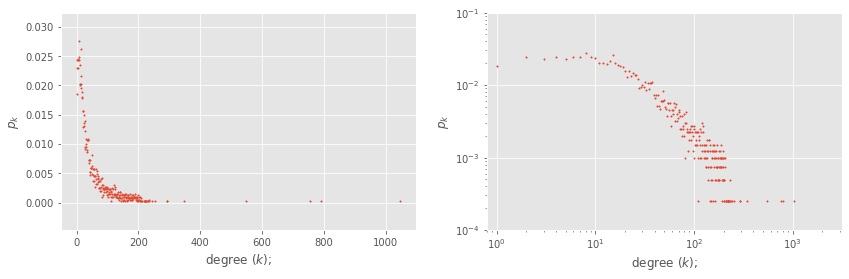

In [5]:
p1.visualize_distribution()

In [7]:
print('alpha: %.4f, c: %.4f' %(p1.fit_params()))

alpha: -1.1802, c: -0.9922


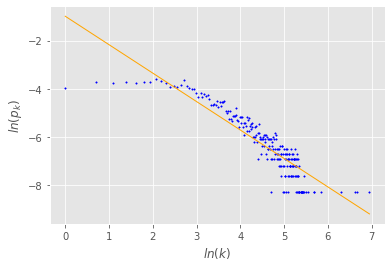

In [8]:
p1.plot_fitted()

***How good is this fit? Is it a scale-free network?***

Given to the plot, it is a scale-free network. Although it fits to the power law acceptably (better for medium k, while worse for very small or very large k); it also displays some similarity to a non-linear preferential attachment model, since the $\alpha$ value is only slightly larger than 1.

In [9]:
p1.model.score(p1.log_k, p1.log_pk)

0.8091782885710821

The score of the model is 0.809, somehow satisfiable, as it is not far from the best possible score 1.0.  

P.S. The `score()` method returns the coefficient of determination R^2 of the prediction. The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum().  
The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

### 1b)

- (b) Detect two largest communities using the modularity maximization approach 

In [21]:
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt

In [11]:
communities = greedy_modularity_communities(G)

In [12]:
for c in communities[:2]:
    print('number of nodes in community: %s' %len(c))
    print('first 20 nodes in community: %s' %list(c)[:20])

number of nodes in community: 983
first 20 nodes in community: ['3374', '1401', '950', '2668', '1521', '1579', '2876', '1588', '2997', '932', '3066', '1163', '2875', '1238', '2894', '2935', '3224', '2730', '1832', '2999']
number of nodes in community: 815
first 20 nodes in community: ['360', '1260', '1129', '521', '1127', '1607', '1032', '1634', '565', '432', '401', '954', '1145', '987', '1739', '1818', '1281', '1640', '1168', '608']


In [94]:
top2 = dict()
for i, v in enumerate(communities[:2]):
    for node in v:
        top2[node] = i

#### Visualize top-2 communities

In [102]:
G2 = G.copy()
for n in G.nodes():
    if n not in top2:
        G2.remove_node(n)

In [103]:
values = [top2[node] for node in G2.nodes()]

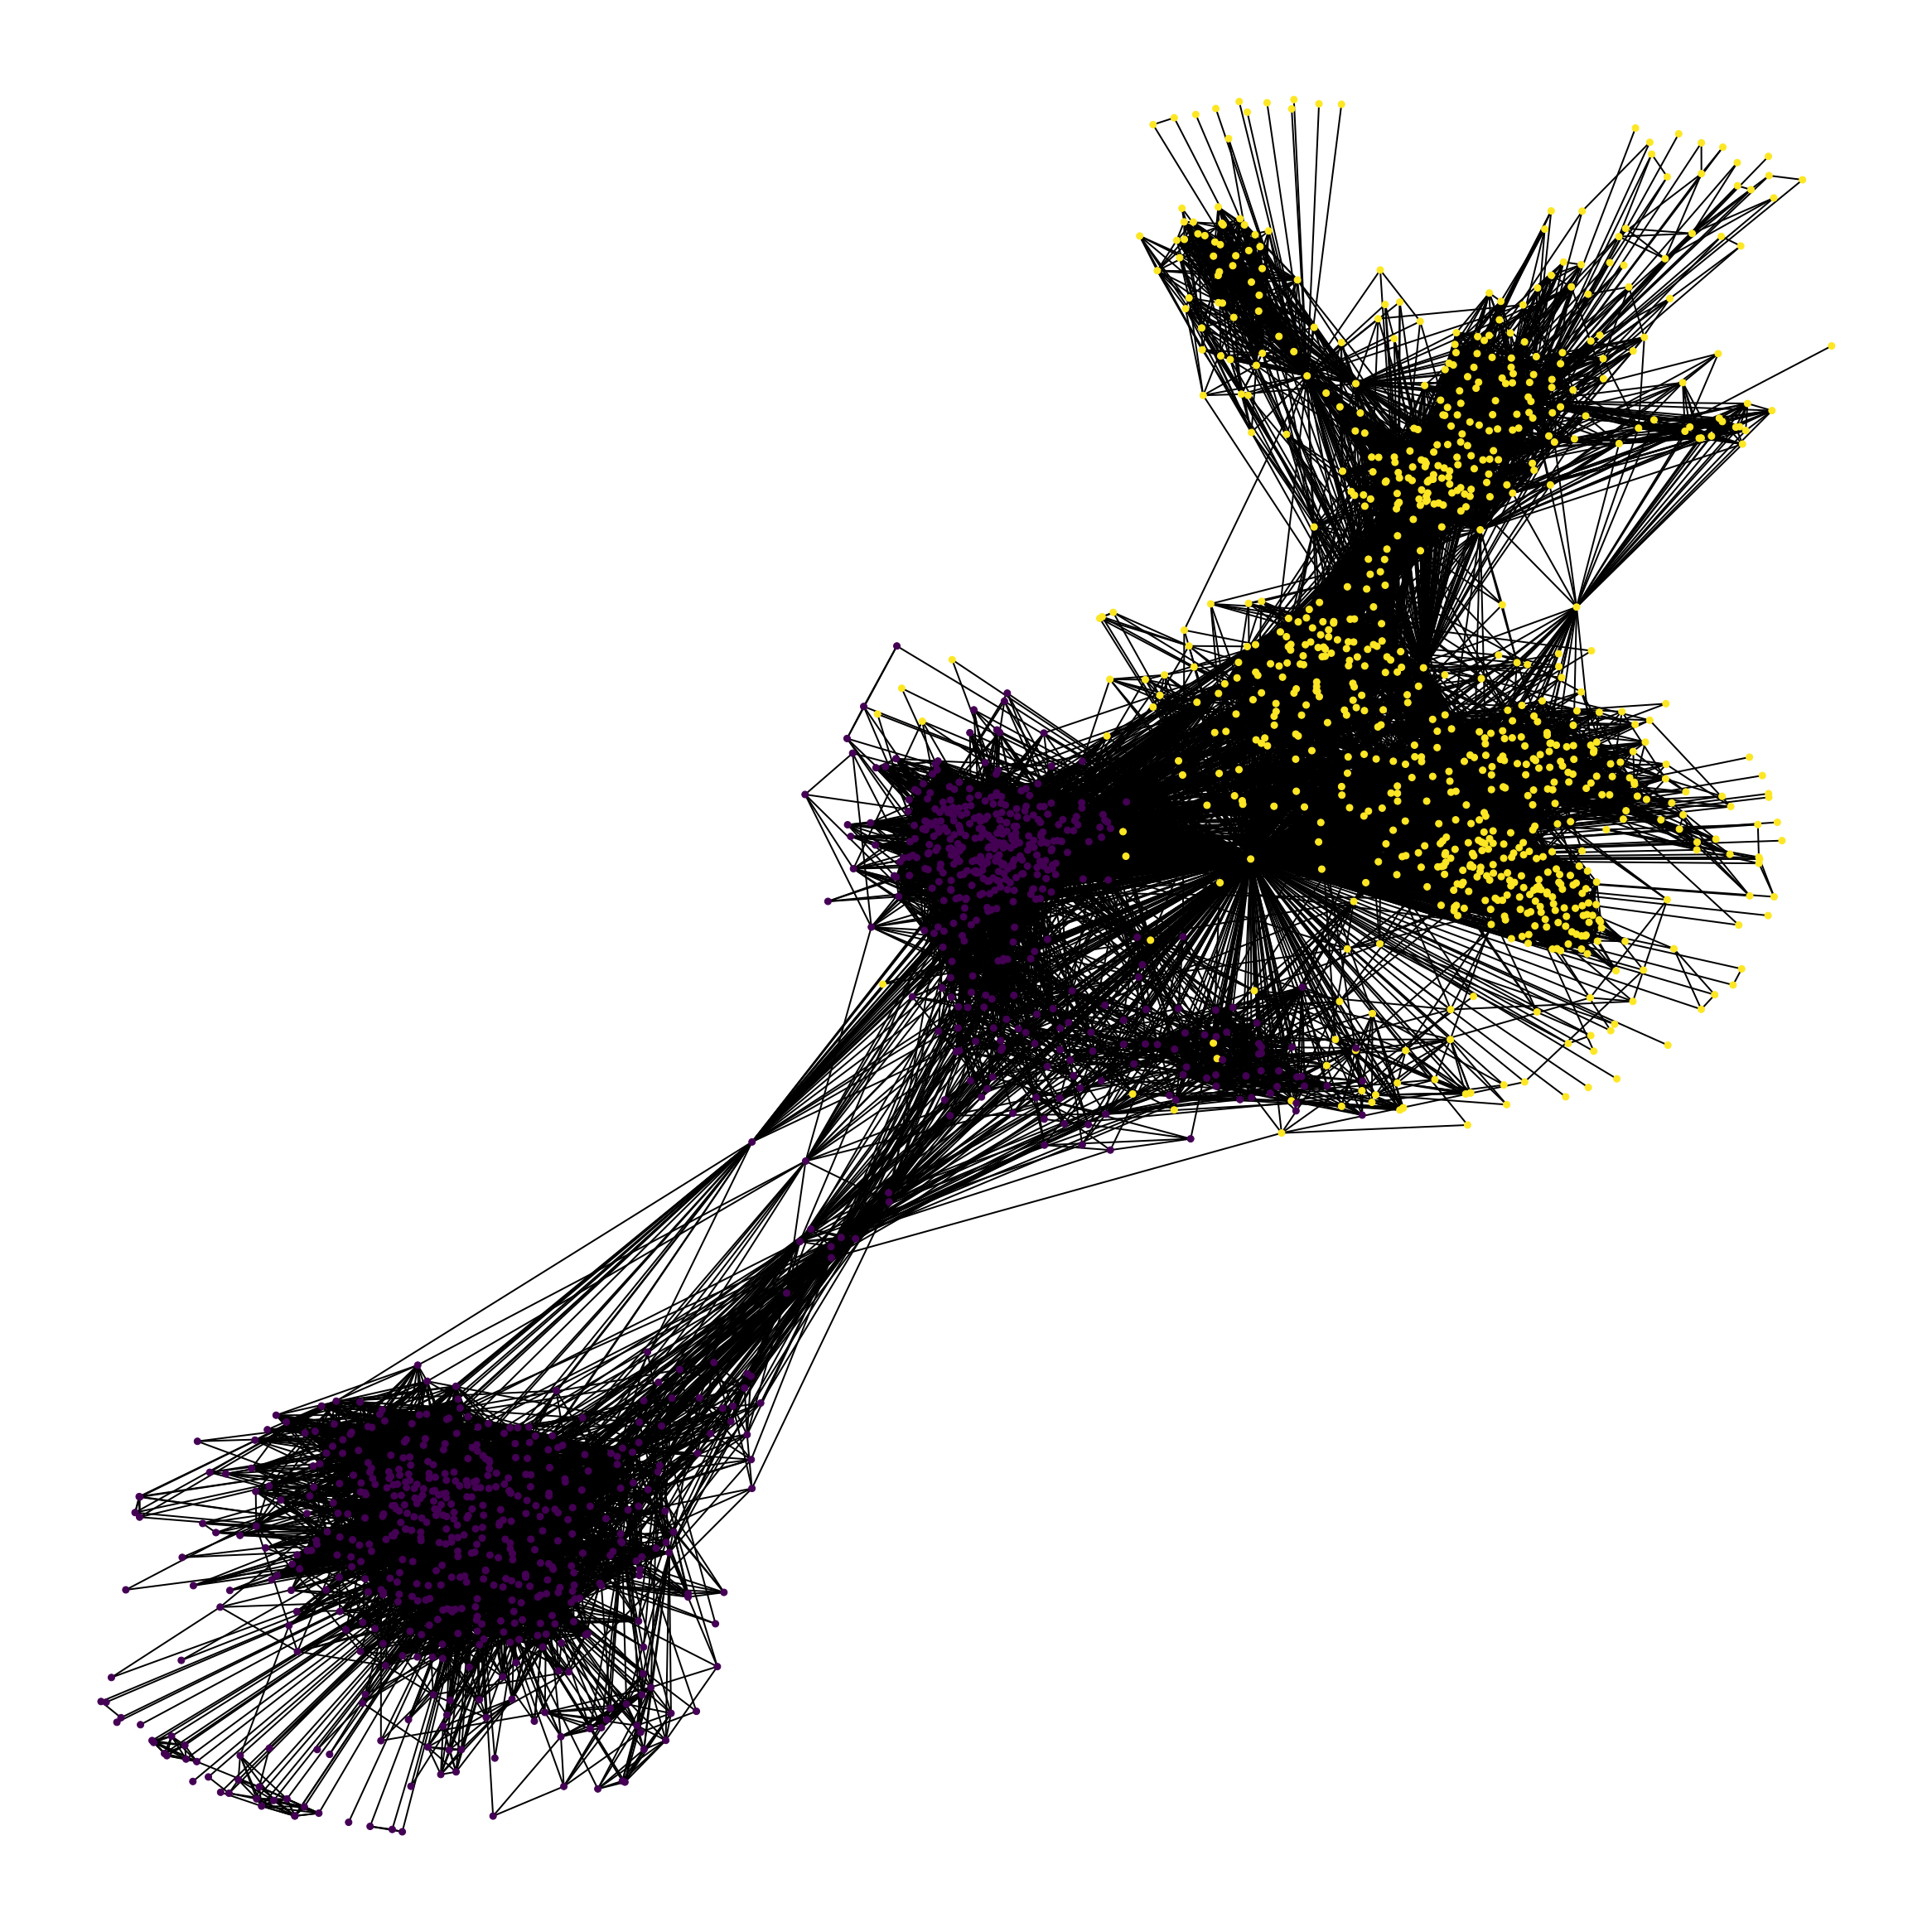

In [125]:
plt.figure(figsize=(16,16))
nx.draw_spring(G2, node_color = values, node_size=16, with_labels=False)
plt.show()

### 1c
- (c) Detect four largest communities using the Louvain/Leuven algorithm

Compute the partition of the graph nodes which maximises the modularity using the Louvain heuristices. This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.

In [13]:
from community import best_partition
from collections import defaultdict

In [14]:
partitions = best_partition(G)

In [15]:
louvain_dict = defaultdict(list)

In [16]:
for p, c in partitions.items():
    louvain_dict[c].append(p)

In [17]:
communities_sorted = sorted(louvain_dict.keys(), key = lambda x: len(louvain_dict[x]), reverse=True)

***Display information about the top 4 communities:***

In [18]:
for k in communities_sorted[:4]:
    print('community %s has %s nodes, with 5 sample nodes %s.' %(k, len(louvain_dict[k]), louvain_dict[k][:5]))

community 7 has 548 nodes, with 5 sample nodes ['1085', '3437', '3454', '3487', '3723'].
community 4 has 535 nodes, with 5 sample nodes ['1684', '3173', '990', '1140', '1450'].
community 2 has 435 nodes, with 5 sample nodes ['107', '897', '899', '904', '906'].
community 1 has 432 nodes, with 5 sample nodes ['34', '173', '198', '348', '414'].


In [126]:
communities_sorted

[7, 4, 2, 1, 3, 0, 5, 9, 13, 12, 6, 8, 11, 10, 14, 15]

#### Visualize top 4 communities

In [129]:
G4 = G.copy()

In [135]:
for n in G.nodes():
    if partitions[n] not in communities_sorted[:4]:
        G4.remove_node(n)

In [137]:
values_4 = [partitions.get(node) for node in G4.nodes()]

/Users/gdkou/.pyenv/versions/3.7.4/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


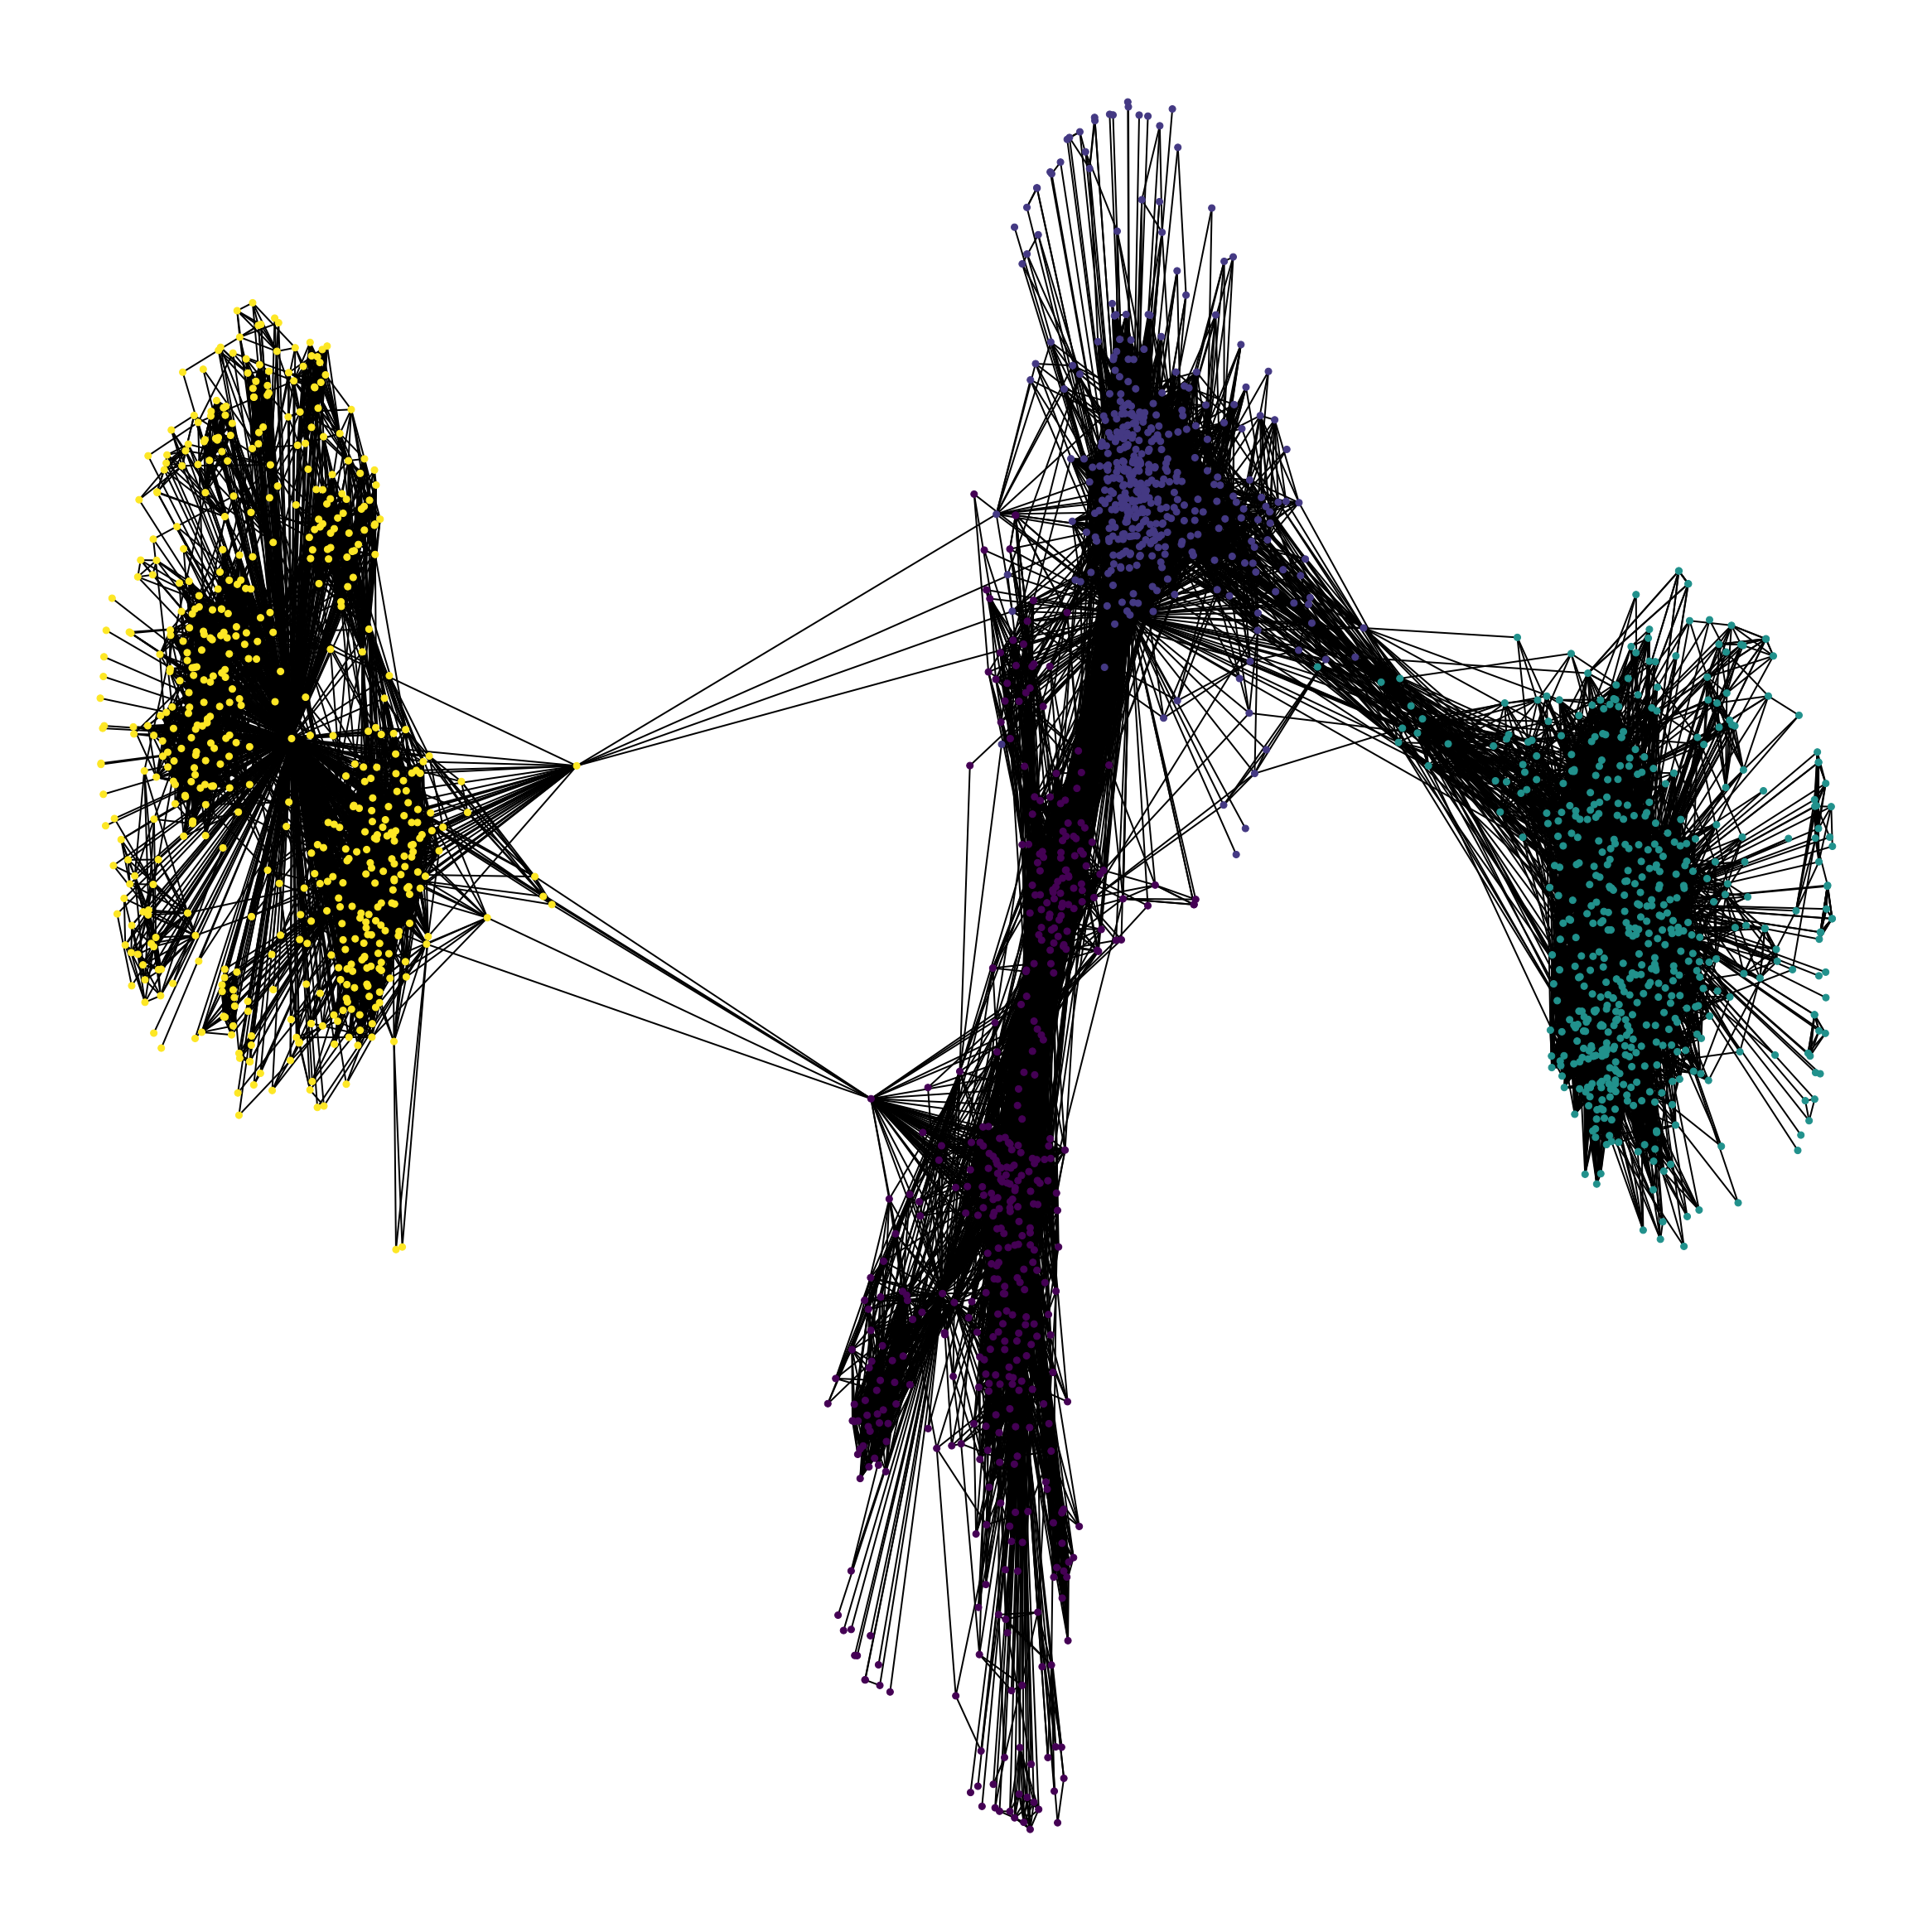

In [140]:
plt.figure(figsize=(16,16))
nx.draw_spring(G4, node_color = values_4, node_size=16, with_labels=False)
plt.show()

## Problem 2

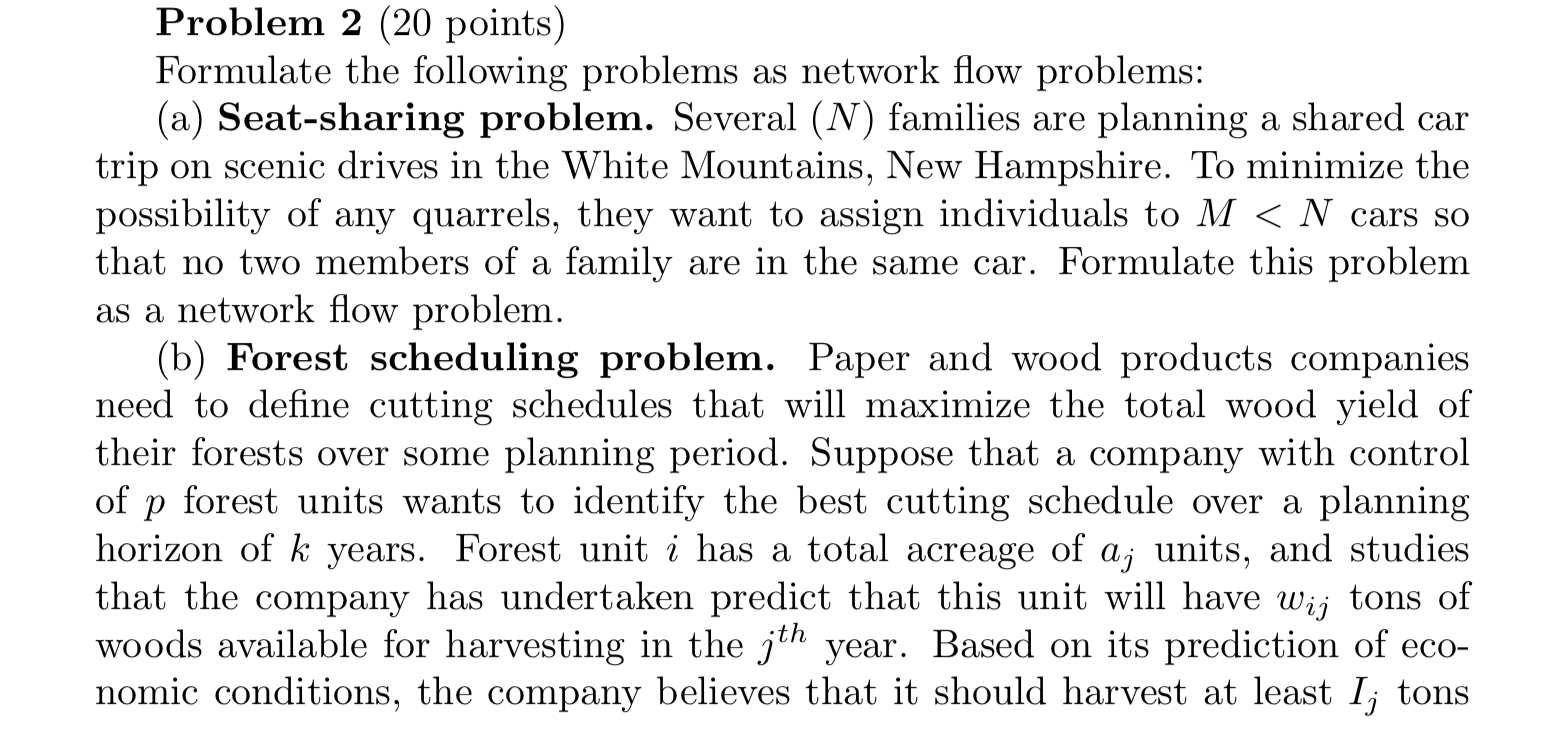

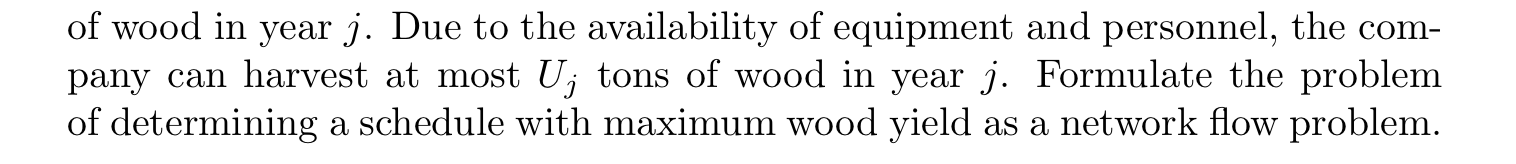

### 2a)

Let $b_i$ denote the number of members in family $i, 1 \leq i \leq N$;  
Let $u_j$ denote the number of seats in car $j, 1 \leq j \leq M $;   
Assume that the total number of seats is enough for all the families, i.e.
$$ 
\sum_{j=1}^{M} u_j \geq \sum_{i=1}^{N} b_i
$$

Consider the family nodes as the supply nodes, and the car nodes as the demand nodes. The seat-sharing problem can be formulated into a network flow problem.    

Restrictions:
- no two members from a family can be in the same car, can be modeled as: from each family node $f_i$ to every car node $c_j$, the upper bound of the arc capability $u_{ij}=1$. The total number of arcs is thus $MN$.
- each family node $f_i$ has a fixed number of people $b_j$
- each car node $c_j$ has a upper bound which is the number of seats $u_j$

Here we plot a simplified network of 3 families with 3 cars.

In [152]:
from graphviz import Digraph

In [392]:
g = Digraph('seat sharing')
g.attr(rankdir='LR', size='8,5')
g.attr('node', shape='circle')
g.node('s')
g.node('t')
num_family = 3
with g.subgraph(name='layer_1') as c:
    c.node_attr.update(style='filled', color='lightblue')
    for f in range(num_family):
        family = 'f' + str(f+1)
        c.node(family)
        c.edge('s', family, label='b' + str(f+1))

num_cars = 3    
with g.subgraph(name='layer_1') as c2:
    c2.node_attr.update(style='filled', color='violet')
    for c in range(num_cars):
        car = 'c' + str(c+1)
        c2.node(car)
        c2.edge(car, 't', label='u' + str(c+1))
        for f in range(num_family):
            family = 'f' + str(f+1)
            c2.edge(family, car, label='1')

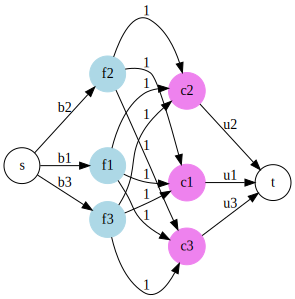

In [393]:
g

### 2b)

Nodes in the network:  
- Layer 1: Each forest unit can be regarded as a supply node in layer 1, with $p$ forest nodes in total. 
- Layer 2: Each harvesting year is modeled as a node in layer 2, connected to all the forest unit nodes in layer 1.
- Layer 3: A super sink $t$ is added at layer 4 and connected to each "harvest year" node in layer 3.
- Layer 0: A super source $s$ is added at layer 0 and connected to each forest node in layer 1.

Edges/arcs in the network: 
- arcs between layer 0 (the super-source node $s$) and layer 1 (forest nodes) have infinite capacity.
- arcs between layer 1 (forest nodes) and layer 2 (year nodes) have capacity $w_{ij}$, meaning that the upper bound of forest unit $i$ wood available at year $j$.
- arcs inside layer 2 have infinite capability, meaning that the remained forest can accumulate for the next year.
- arcs between layer 2 (harvesting year nodes) and layer 3 (the super sink $t$) have capability $(I_j, U_j)$, meaning that the harvest at year $j$ has lower bound $I_j$ and upper bount $U_j$.

The target is to maximiz the flow at the super sink, which is equivalent to the maximum wood yield in $k$ years, subject to the constraints of arcs' capabilities.

Here we plot a network with 3 forest units and 3 years of planning.

In [587]:
h = Digraph('forest scheduling')
h.attr(rankdir='LR')
h.attr('node', shape='circle')
h.node('s')
h.node('t')

num_units = 3
with h.subgraph(name='cluster_units') as c:
    c.attr(color='blue')
    c.node_attr.update(style='filled', color='lightgreen')
    for f in range(num_units):
        u = 'unit ' + str(num_units-f)
        c.node(u)


for i in range(num_units):
    h.edge('s', 'unit ' + str(num_units-i), label='+oo')


num_years = 3
with h.subgraph(name='cluster_years') as c2:
    c2.attr(rankdir='TB', color='blue')
    c2.node_attr.update(style='filled', color='orange', rankdir='TB')
    for y in range(num_years):
        y_string = str(num_years - y)
        year = 'year ' + y_string
        c2.node(year)
        
    c2.edge('year 1', 'year 2', label='+oo')
    c2.edge('year 2', 'year 3', label='+oo')

for i in range(num_years):
    y_string = str(num_years - i)
    year = 'year ' + y_string
    h.edge(year, 't', label='(I_%s, U_%s)' % (y_string, y_string))
    for f in range(num_units):
        u = 'unit ' + str(num_units-f)
        h.edge(u, year, label='w%s%s' %(f, num_years-i))
        
    

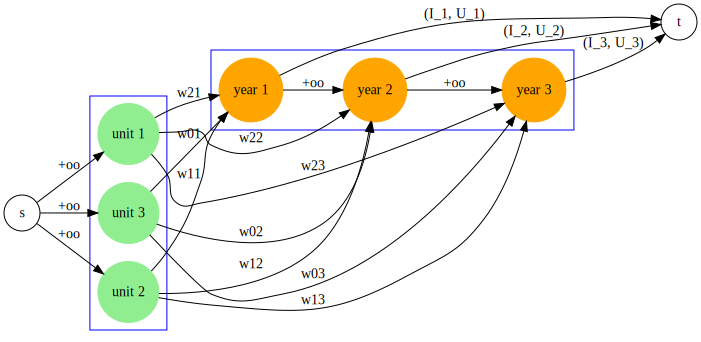

In [588]:
h

## Problem 3

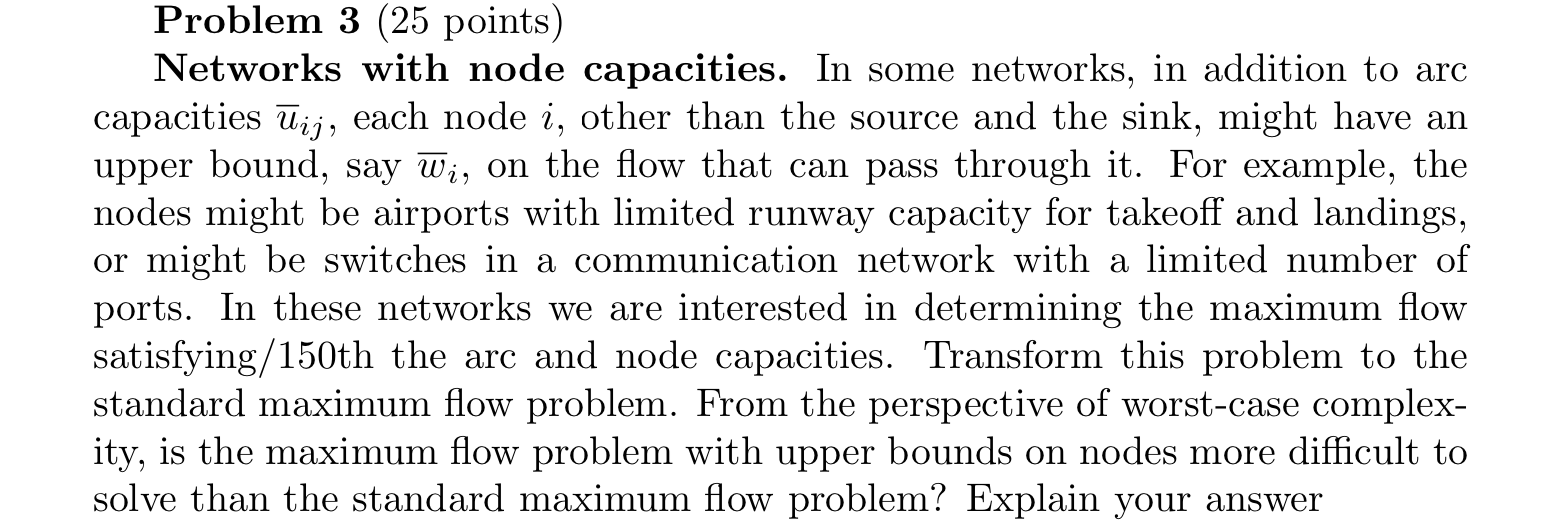

No, the complexity with node capacities is the same as standard maximum flow problem, since the max-flow with node capacities can be reduced to the regular max-flow problem with the following approach.  

1) For the given graph $G$ with arc capacities $u_{ij}$ and node capacities $w_i$, we build a nother graph $G'$ with the same arc capacities $u_{ij}$;  
2) In addition, for each node $v$ in G with capacity $w_i$, we make it to two nodes $v_1$ and $v_2$, so that the node capacity of $v$ in $G$, is equivalent to the arc capacity between $v_1$ and $v_2$ in $G'$.

Proof 
- For any arbitrary flow $f$ in G, satisfiying the node capacity, can be converted to a flow $f'$ in $G'$ which satisfies the edge capacity constraints. For any node $\forall v \in G, \sum f_{in}(v) = \sum f_{out}(v)$, where $c_v$ is the capacity of node $v$. Thus, $f'(v_1, v_2) = \sum f_{in}(v) = \sum f_{out}(v) \leq c_v $.
- Similarly, any flow $f'$ in $G'$ can be converted to a flow in G, which satisfies the node capability constraints. 

## Problem 4

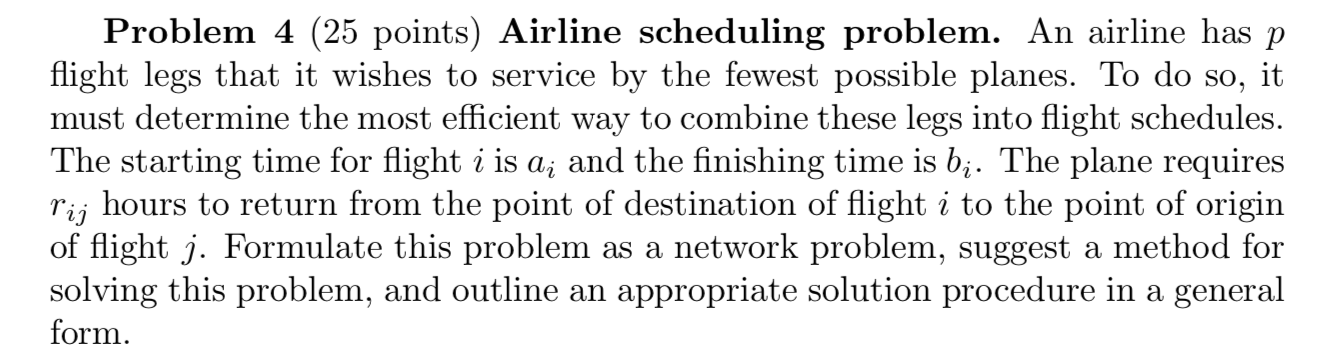

#### Formulation of problem
This problem can be modeled as a directed graph G over the flight legs. 
- Add an edge $e_i = (a_i \to b_i)$ for each leg $i$, and set the lower bound on $e_i$ to be 1, to guarantee that each flight on the list is served. In addition, also set the capacity of $e_i$ to be 1, to avoid duplicate scheduling. Thus, $l(e_i) = c(e_i) = 1$.
- Add a source vertex $s$ and a sink vertext $t$ to G. Set the demand at $t$ as $k$, and the supply at $s$ as $−k$ (meaning $k$ units of flow are leaving $s$ and need to arrive to $t$).
- Add an edge Two flight legs $i$ and $j$ can be connected if the same plane can be used for both flights, i.e. $a_j \geq b_i + r_{ij}$; in this case, the same airplane can perform leg $i$ afterwards severs leg $j$; thus, G is an acyclic graph.
- A super-souce node and a super-sink node should be created, with the super-source connected to the each of the start node, and the super-sink connected to the end of each leg node. These arcs denote sheduling a plane into service or removing a plane from service.

Thus, the problem becomes to find the minimun value of $k$, i.e. the fewest number of plane, with restrictions of the edge flow bounds.

### Solution

The basic idea is to perform a reduction of this problem to the computation of circulation. 

a directed graph G should be constructed as follows:

- For every leg i, we introduce two vertices $u_i, v_i \in V(G)$. Add a source vertex $s$ and a sink vertext $t$ to H. Set the demand at $t$ as $k$, and the supply at $s$ as $−k$ (meaning $k$ units of flow are leaving $s$ and need to arrive to $t$).
- Add an edge $e_i = (a_i \to b_i)$ for each leg $i$, and set the lower bound on $e_i$ to be 1, to guarantee that each flight on the list is served. In addition, also set the capacity of $e_i$ to be 1, to avoid duplicate scheduling. Thus, $l(e_i) = c(e_i) = 1$.
- If the same plain can perform both flights $i$ and $j$, i.e. $(i,j) \in E(H)$, then add an edge $(b_i \to a_j)$ with capacity 1 to G, but without lower bound, since it is only optional, not obligatory to schedule $i$ and $j$ consecutively. 
- Since any airplane can start the day with flight i, we add an edge $(s \to a_i)$ with capacity 1 to G, for all flights $i$; Similarly, add an edge $b_j \to t$ with capacity 1 to G for all flights $j$, as any airplane can end the day after serving flight $j$.
- If there is extra planes, they may not be used. As such, an overflow edge $(s \to t)$ with capacity $k$ is added, meaning that all the unused airplanes can be carried from $s$ directly to $t$.

It can be proven that there is a way to perform all flights using at most $k$ planes if and only if there is a feasible circulation in the network G.

Proof:  
Assume there is a way to perform the flights using k′ ≤ k flights. Consider such a feasible schedule. The schedule of an airplane in this schedule defines a path π in the network H that starts at s and ends at t, and we send one unit of flow on each such path. We also send k − k′ units of flow on the edge (s → t). Since the schedule is feasible, all legs are being served by some airplane(s). As such, all the “middle” edges with lower-bound 1 are being satisfied. Thus, this results is a valid circulation in G that satisfies all the given constraints.

In [526]:
g4 = Digraph('airline scheduling')
g4.attr('node', shape='circle')
g4.attr('edge', style='solid', color='black')
g4.node('s')
g4.node('t')
g4.edge('s', 't', label='k')

num_kegs = 6
with g4.subgraph(name='cluster_start') as c:
    c.attr(color='none')
    c.node_attr.update(style='filled', color='cyan')
    for f in range(num_kegs):
        u = 'u_' + str(f+1)
        c.node(u)


with g4.subgraph(name='cluster_end') as c2:
    c2.attr(color='none')
    c2.node_attr.update(style='filled', color='lightgray')
    for f in range(num_kegs):
        v = 'v_' + str(f+1)
        c2.node(v)

for i in range(num_kegs):
    g4.edge('s', 'u_' + str(i+1))
    g4.edge('u_' + str(i+1), 'v_' + str(i+1), label='(1,1)')

g4.edges([('v_' + str(i+1), 't') for i in range(num_kegs)])        
g4.attr('edge', style='dashed',  color='violet')
g4.edge_attr.update(style='dashed', color='violet')
g4.edges([('v_1', 'u_2'),('v_1', 'u_3'), ('v_2', 'u_3'), ('v_4', 'u_5')])
g4.graph_attr.update(color='blue')

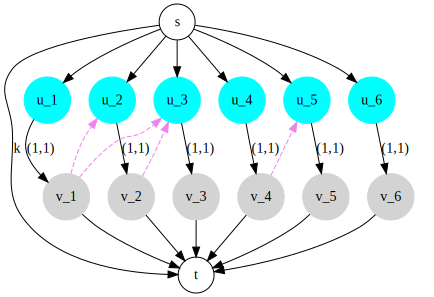

In [527]:
g4

---
The source code of this Jupyter Notebook will only be pushed to [Guandong Kou's GitHub repository](https://github.com/Kou-Guandong/NYU_9293_Network_Science_and_Optimization) after the due date.